# **Reference Curves for Skin Friction Coefficient**

In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# increase dpi and use latex rendering
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

# Set macro for paths
run = "../run/"
!mkdir -p output

## **1. Setup the Related Values**
'*nuInf*' is calculated from the literature of *Wieghardt* (1944) with the 5m plate and Re = 10^7.

In [2]:
# nuInf1 = 5*17.8/10^7
UInf1 = 17.8
nuInf1 = 8.9e-06

# nuInf2 = 5*33.0/10^7
UInf2 = 33.0
nuInf2 = 1.65e-05

## **2. Load data to show *Wieghardt* plot in **OpenFOAM****

In [3]:
UInf = 69.4
nuInf = 1.388e-05
model = "kOmegaSST"
yp = ['0.05', '1', '2', '5', '10', '30', '50', '100']
res_list = ['1e-3', '1e-4', '1e-5', '1e-6']

tauw_path = [run + 'turbulentFlatPlate/yplus_{}/tauw_{}_{}_{}.csv'.format(yp[j], model, yp[j], res_list[i]) for j in range(len(yp)) for i in range(len(res_list))]
tauw_data = [pd.read_csv(tauw_path[i + len(res_list)*j], delim_whitespace=True) for j in range(len(yp)) for i in range(len(res_list))]
tauw_data[0].head()

,ccx,tau_xx,tau_yy,tau_zz
0,0.000486,-48.7743,-0.967428,0
1,0.001458,-19.8739,-0.005168,0
2,0.002433,-14.5191,-0.001111,0
3,0.003410,-12.3327,-0.000505,0
4,0.004390,-11.0983,-0.000300,0


## **3-1. First Experimental Data (U = 17.8 m/s) in the Literature of *Wieghardt***

In [4]:
Cf_path1 = 'output/c_f_curve_1.csv'
Cf_data1 = pd.read_csv(Cf_path1)
Cf_data1.head()

,x,Curve1
0,0.17196,0.004701
1,0.27116,0.004252
2,0.38360,0.003923
3,0.47619,0.003614
4,0.79365,0.003453


## **3-2. Second Experimental Data (U = 33.0 m/s) in the Literature of *Wieghardt***

In [5]:
Cf_path2 = 'output/c_f_curve_2.csv'
Cf_data2 = pd.read_csv(Cf_path2)
Cf_data2.head()

,x,Curve1
0,0.15923,0.005110
1,0.26303,0.004293
2,0.35448,0.003815
3,0.47252,0.003376
4,0.65101,0.003257


## **4-1. Calculating the Coefficients of the First Experiment**

In [6]:
Rex1 = Cf_data1['x']*UInf1/nuInf1
Cf1 = Cf_data1['Curve1']

## **4-2. Calculating the Coefficients of the Second Experiment**

In [7]:
Rex2 = Cf_data2['x']*UInf2/nuInf2
Cf2 = Cf_data2['Curve1']

## **4-3. Calculating the Reference Data**

In [8]:
Rex = (tauw_data[0]['ccx'])*UInf/nuInf
wieghardt = 0.288*(np.log10(Rex))**(-2.45)
prandtl = 0.455*(np.log10(Rex))**(-2.58)

## **5. Plot the Experimental Data with the Reference Curves**

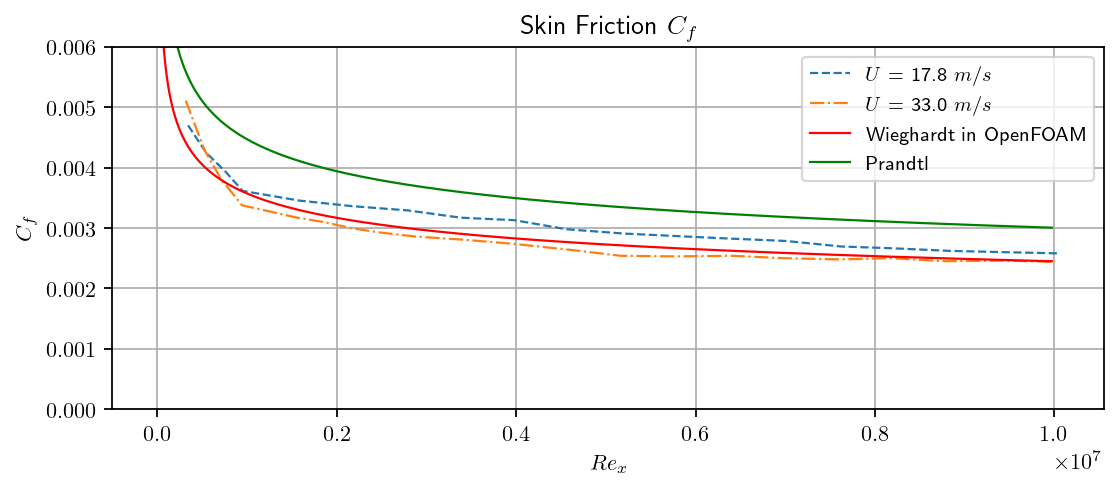

In [9]:
style = ["-", "--", "-.", ":"]
lw = 1.0

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.006])
plt.grid()
ax.set_xlabel(r"$Re_x$")
ax.set_ylabel(r"$C_f$")
plt.title(r"Skin Friction $C_f$")
ax.plot(Rex1, Cf1, label = "$U$ = 17.8 $m/s$", ls = style[1], c = "C{:d}".format(0), lw = lw)
ax.plot(Rex2, Cf2, label = "$U$ = 33.0 $m/s$", ls = style[2], c = "C{:d}".format(1), lw = lw)
ax.plot(Rex, wieghardt, color = "r", label = "Wieghardt in OpenFOAM", lw = lw)
ax.plot(Rex, prandtl, color = "g", label = "Prandtl", lw = lw)
ax.legend(fontsize = 9)

## **6-1. Functions for a Regression Method**

In [10]:
def PrandtlEq (Rex, m, p, n):
    c_f = m*(np.log10(Rex) + p)**(-n)
    return c_f

def CostFunc (c_f1, Cf1, c_f2, Cf2):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    cost = 1/(2*train_m1)*np.dot(c_f1 - Cf1, c_f1 - Cf1) + 1/(2*train_m2)*np.dot(c_f2 - Cf2, c_f2 - Cf2)
    return cost

def dJdm (c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    dm = (1/train_m1)*np.dot(c_f1 - Cf1, (np.log10(Rex1) + p)**(-n)) + (1/train_m2)*np.dot(c_f2 - Cf2, (np.log10(Rex2) + p)**(-n))
    return dm

def dJdp (c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    dp = (1/train_m1)*np.dot(c_f1 - Cf1, m*(-n)*(np.log10(Rex1) + p)**(-n-1)) + (1/train_m2)*np.dot(c_f2 - Cf2, m*(-n)*(np.log10(Rex2) + p)**(-n-1))
    return dp

def dJdn (c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    dn = (1/train_m1)*np.dot(c_f1 - Cf1, m*(-np.log(np.log10(Rex1) + p))*((np.log10(Rex1) + p)**(-n))) + (1/train_m2)*np.dot(c_f2 - Cf2, m*(-np.log(np.log10(Rex2) + p))*((np.log10(Rex2) + p)**(-n)))
    return dn

## **6-2. Execution of the Regression Method**

Both experimental data 1 and 2 are used to calculate the cost function. Therefore, the regression method also uses both of data.

In [11]:
m = 0.400
p = 0
n = 2.0
alpha_m = 10
alpha_p = 1
alpha_n = 50

oldcost = 0
cost = 1
epoch = 0

while(abs(cost - oldcost) > 1e-12):
    c_f1 = PrandtlEq(Rex1, m, p, n)
    c_f2 = PrandtlEq(Rex2, m, p, n)
    oldcost = cost
    m -= alpha_m*dJdm(c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n)
    p -= alpha_p*dJdp(c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n)
    n -= alpha_n*dJdn(c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n)
    cost = CostFunc(c_f1, Cf1, c_f2, Cf2)
    epoch += 1    
    if (epoch%1000 == 0):
        print(abs(cost - oldcost))

print("epoch :{}, m : {}, p : {}, n : {}, cost : {}".format(epoch, m, p, n, cost))

epoch :824, m : 0.27104915690514836, p : 0.0014898910258827752, n : 2.4004535395930917, cost : 3.504339891624456e-08


## **7. Plot the Regression Curve with the Experimental Data Curve**

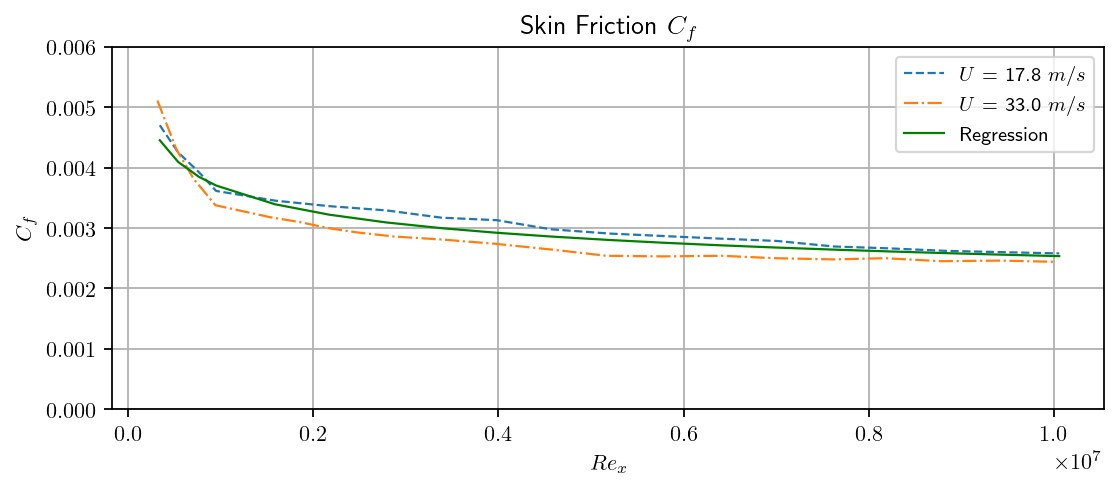

In [12]:
style2 = ["-", "--", "-.", ":"]
lw2 = 1.0

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.006])
plt.grid()
ax2.set_xlabel(r"$Re_x$")
ax2.set_ylabel(r"$C_f$")
plt.title(r"Skin Friction $C_f$")
ax2.plot(Rex1, Cf1, label = "$U$ = 17.8 $m/s$", ls = style2[1], c = "C{:d}".format(0), lw = lw2)
ax2.plot(Rex2, Cf2, label = "$U$ = 33.0 $m/s$", ls = style[2], c = "C{:d}".format(1), lw = lw)
ax2.plot(Rex1, PrandtlEq(Rex1, m, p, n), label = "Regression", ls = style2[0], c = 'g', lw = lw2)
ax2.legend(fontsize = 9)